In [12]:
#gwr approach based on https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a
#however, this tutorial seems to no longer exist
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import geopandas as gpd

import libpysal as ps

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

%matplotlib inline 

In [13]:
#this version is depricated for its inability to handle data from 2015 or
'''def regressGrades(file, longitude, latitude, band, topic, demographic, year, treq, output):
    # Performs a GWR on the math or reading scores of students in 2014 or 2015 based on pollution exposure estimates
    # and American Community Survey attested demographic characteristics including block group median income, population
    # size, adult education levels, and career makeups.
    
    # Requires that the data follow a specific labelling guide, which will have been noted in comments above.
    File is the file path. Longitude and Latitude are the XY coordinates of the centroid of each polygon. band is a 
    bandwidth, which I had to manually input due to issues with the library failing to calculate reasonable bandwidths. 
    Topic is either math or read, used to select which grades will be analyzed as the dependant variable. Demographic 
    can be 'overall', 'white', 'black', 'native', 'asian', 'pacific', or 'multi', and is used in selecting the dependent 
    and independent variables. Year is the year to be computed, and is used in selecting the dependent and 
    independent variables. treq is the desired t-value for statistical significance.
    
    Output is the location to which you want your plots and other outputs saved. Set to 'no' if you do not wish to have
    anything saved.
    
    gdf  = gpd.read_file(file)
    
    #this section automatically constructs all of the strings that will be used to select the data to be used
    
    if topic == 'read':
        dep = 'r'
    elif topic == 'math':
        dep = 'm'
    else: 
        print('invalid topic, please enter read or math')
        return
    
    if year == '2014':
        end = '14'
    elif year == '2015':
        end = '15'
    else:
        print('invalid year, please enter 2014 or 2015')
        return

    if demographic == 'overall':
        ent = '_over'
        demo = 'Over'
    elif demographic == 'white':
        ent = '_whi'
        demo = 'White'
    elif demographic == 'black':
        ent = '_bla'
        demo = 'Black'
    elif demographic == 'native':
        ent = '_nati'
        demo = 'Nativ'
    elif demographic == 'asian':
        ent = '_asi'
        demo = 'Asian'
    elif demographic == 'pacific':
        ent = '_paci'
        demo = 'Pacif'
    elif demographic == 'multi':
        ent = '_mul'
        demo = 'Multi'
    else:
        print('Invalid demographic.')
        return
        
    dependent = dep + end + ent
    
    pollution = demo + 'Pol' + end
    
    income = demo + 'Inc' + end
    
    population = demo + 'Pop' + end

    education = demo + 'Sch' + end
    
    business = demo + 'Bus' + end

    science = demo + 'Sci' + end
        
    educationAndLegal = demo + 'Edl' + end

    healthcare = demo + 'Hea' + end
    
    service = demo + 'Ser' + end
    
    salesAndOffice = demo + 'Sal' + end

    extraction = demo + 'Ext' + end
    
    logistics = demo + 'Log' + end

    independent = [pollution, income, population, education, business, science, educationAndLegal, healthcare, service, 
                   salesAndOffice, extraction, logistics]
    
    y = gdf[dependent].values.reshape((-1,1)) # reshape is needed to have column array
    y.shape

    X = gdf[independent].values
    X.shape

    u = gdf[longitude]
    v = gdf[latitude]
    coords = list(zip(u,v))
    
    gwr_results = GWR(coords, y, X, bw=band).fit()
        
    suma = gwr_results.summary()
    
    suma
    
    sumadest = output + dependent + '_suma.txt'
    
    #doesn't work properly because they didn't make .summary give a string, please save manually
    #https://www.pythontutorial.net/python-basics/python-create-text-file/
    with open(sumadest, 'w') as f:
        f.write(str(suma))
    
    print('Mean R2 =', gwr_results.R2)
    print('AIC =', gwr_results.aic)
    print('AICc =', gwr_results.aicc)
    
    r2 = 'gwr' + dependent + 'R2'
    
    gdf[r2] = gwr_results.localR2
    
    location = output + dependent + '.png'
    
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf.plot(column=r2, cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
    ax.set_title(r2, fontsize=12)
    ax.axis("off")
    plt.savefig(location ,dpi=150, bbox_inches='tight')
    plt.show()
    
    inter = 'gwr' + dependent + '_intercept'
    
    gdf[inter] = gwr_results.params[:,0]
    gdf[pollution] = gwr_results.params[:,1]
    gdf[income] = gwr_results.params[:,2]
    gdf[population] = gwr_results.params[:,3]
    gdf[education] = gwr_results.params[:,4]
    gdf[business] = gwr_results.params[:,5]
    gdf[science] = gwr_results.params[:,6]
    gdf[educationAndLegal] = gwr_results.params[:,7]
    gdf[healthcare] = gwr_results.params[:,8]
    gdf[service] = gwr_results.params[:,9]
    gdf[salesAndOffice] = gwr_results.params[:,10]
    gdf[extraction] = gwr_results.params[:,11]
    gdf[logistics] = gwr_results.params[:,12]

    gwr_math_filtered_t = gwr_results.filter_tvals(alpha = treq)
    gwr_math_filtered_tc = gwr_results.filter_tvals()

    t = pd.DataFrame(gwr_math_filtered_t)
    tc = pd.DataFrame(gwr_math_filtered_tc)
    
    t
    tc
    
    tdest = output + dependent + '_t.csv'
    tcdest = output + dependent + '_tc.csv'
    
    t.to_csv(tdest)
    tc.to_csv(tcdest)
    
    LCC, VIF, CN, VDP = gwr_results.local_collinearity()

    vif = pd.DataFrame(VIF)
    roundedVif =pd.DataFrame(VIF).describe().round(2)
    cn = pd.DataFrame(CN)
    
    vif
    roundedVif
    cn
    
    vifdest = output + dependent + '_vif.csv'
    rvifdest = output + dependent + '_rvif.csv'
    cndest = output + dependent + '_cn.csv'

    vif.to_csv(vifdest)
    roundedVif.to_csv(rvifdest)
    cn.to_csv(cndest)
    
    cnf = demo + 'CN' + end
    
    gdf[cnf] = CN
    
    return gdf'''

'def regressGrades(file, longitude, latitude, band, topic, demographic, year, treq, output):\n    # Performs a GWR on the math or reading scores of students in 2014 or 2015 based on pollution exposure estimates\n    # and American Community Survey attested demographic characteristics including block group median income, population\n    # size, adult education levels, and career makeups.\n    \n    # Requires that the data follow a specific labelling guide, which will have been noted in comments above.\n    File is the file path. Longitude and Latitude are the XY coordinates of the centroid of each polygon. band is a \n    bandwidth, which I had to manually input due to issues with the library failing to calculate reasonable bandwidths. \n    Topic is either math or read, used to select which grades will be analyzed as the dependant variable. Demographic \n    can be \'overall\', \'white\', \'black\', \'native\', \'asian\', \'pacific\', or \'multi\', and is used in selecting the depende

In [14]:
def altReg(file, longitude, latitude, band, topic, demographic, year, treq, output, c):
    # Performs a GWR on the math or reading scores of students in 2014 or 2015 based on pollution exposure estimates
    # and American Community Survey attested demographic characteristics including
    # size, adult education levels, and career makeups.
    
    # Requires that the data follow a specific labelling guide, which will have been noted in comments above.
    '''File is the file path. Longitude and Latitude are the XY coordinates of the centroid of each polygon. band is a 
    bandwidth, which I had to manually input due to issues with the library failing to calculate reasonable bandwidths. 
    Topic is either math or read, used to select which grades will be analyzed as the dependant variable. Demographic 
    can be 'overall', 'white', 'black', 'native', 'asian', 'pacific', or 'multi', and is used in selecting the dependent 
    and independent variables. Year is the year to be computed, and is used in selecting the dependent and 
    independent variables. treq is the desired t-value for statistical significance.
    
    Output is the location to which you want your plots and other outputs saved. Set to 'no' if you do not wish to have
    anything saved.'''
    
    #income, population, and percentage working in the services were cut due to causing errors with 2015 elementary and all
    #middle school analyses

    
    gdf  = gpd.read_file(file)
    
    #this section automatically constructs all of the strings that will be used to select the data to be used
    
    if topic == 'read':
        dep = 'r'
    elif topic == 'math':
        dep = 'm'
    else: 
        print('invalid topic, please enter read or math')
        return
    
    if year == '2014':
        end = '14'
    elif year == '2015':
        end = '15'
    else:
        print('invalid year, please enter 2014 or 2015')
        return

    if demographic == 'overall':
        ent = '_over'
        demo = 'Over'
    elif demographic == 'white':
        ent = '_whi'
        demo = 'White'
    elif demographic == 'black':
        ent = '_bla'
        demo = 'Black'
    elif demographic == 'native':
        ent = '_nati'
        demo = 'Nativ'
    elif demographic == 'asian':
        ent = '_asi'
        demo = 'Asian'
    elif demographic == 'pacific':
        ent = '_paci'
        demo = 'Pacif'
    elif demographic == 'multi':
        ent = '_mul'
        demo = 'Multi'
    else:
        print('Invalid demographic.')
        return
        
    dependent = dep + end + ent
    
    pollution = demo + 'Pol' + end
    
    '''income = demo + 'Inc' + end
    business = demo + 'Bus' + end

    science = demo + 'Sci' + end
        
    educationAndLegal = demo + 'Edl' + end

    healthcare = demo + 'Hea' + end
        
    salesAndOffice = demo + 'Sal' + end

    extraction = demo + 'Ext' + end
    
    logistics = demo + 'Log' + end'''

    independent = [pollution]
    
    y = gdf[dependent].values.reshape((-1,1)) # reshape is needed to have column array
    y.shape

    X = gdf[independent].values
    X.shape

    u = gdf[longitude]
    v = gdf[latitude]
    coords = list(zip(u,v))
    
    gwr_results = GWR(coords, y, X, bw=band).fit()
        
    suma = gwr_results.summary()
    
    suma
    
    sumadest = output + dependent + '_suma.txt'
    
    #doesn't work properly because they didn't make .summary give a string, please save manually
    #https://www.pythontutorial.net/python-basics/python-create-text-file/
    with open(sumadest, 'w') as f:
        f.write(str(suma))
    
    print('Mean R2 =', gwr_results.R2)
    print('AIC =', gwr_results.aic)
    print('AICc =', gwr_results.aicc)
    
    r2 = 'gwr' + dependent + 'R2'
    
    gdf[r2] = gwr_results.localR2
    
    location = output + dependent + '.png'
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    #sometimes, there aren't enough unique r^2s for a multi-class GWR
    
    gdf.plot(column=r2, cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=c, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
    ax.set_title(r2, fontsize=12)
    ax.axis("off")
    plt.savefig(location ,dpi=150, bbox_inches='tight')
    plt.show()
    
    inter = 'gwr' + dependent + '_intercept'
    
    gdf[inter] = gwr_results.params[:,0]
    gdf[pollution] = gwr_results.params[:,1]
    ''' gdf[income] = gwr_results.params[:,2]
    gdf[business] = gwr_results.params[:,2]
    gdf[science] = gwr_results.params[:,3]
    gdf[healthcare] = gwr_results.params[:,4]
    gdf[educationAndLegal] = gwr_results.params[:,5]
    gdf[salesAndOffice] = gwr_results.params[:,6]
    gdf[extraction] = gwr_results.params[:,7]
    gdf[logistics] = gwr_results.params[:,8]'''

    gwr_math_filtered_t = gwr_results.filter_tvals(alpha = treq)
    gwr_math_filtered_tc = gwr_results.filter_tvals()

    t = pd.DataFrame(gwr_math_filtered_t)
    tc = pd.DataFrame(gwr_math_filtered_tc)
    
    t
    tc
    
    tdest = output + dependent + '_t.csv'
    tcdest = output + dependent + '_tc.csv'
    
    t.to_csv(tdest)
    tc.to_csv(tcdest)
    
    LCC, VIF, CN, VDP = gwr_results.local_collinearity()

    vif = pd.DataFrame(VIF)
    roundedVif =pd.DataFrame(VIF).describe().round(2)
    cn = pd.DataFrame(CN)
    
    vif
    roundedVif
    cn
    
    vifdest = output + dependent + '_vif.csv'
    rvifdest = output + dependent + '_rvif.csv'
    cndest = output + dependent + '_cn.csv'

    vif.to_csv(vifdest)
    roundedVif.to_csv(rvifdest)
    cn.to_csv(cndest)
    
    cnf = demo + 'CN' + end
    
    gdf[cnf] = CN
    

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2786.852
Log-likelihood:                                                    -126.266
AIC:                                                                256.532
AICc:                                                               259.306
BIC:                                                               2669.525
R2:                                                                   0.238
Adj. R2:                                                              0.215

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

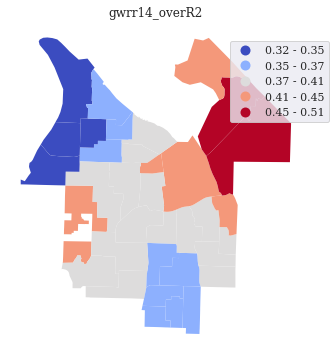

ValueError: Input must be 1- or 2-d.

In [15]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'overall', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1515.814
Log-likelihood:                                                    -115.609
AIC:                                                                235.218
AICc:                                                               237.992
BIC:                                                               1398.488
R2:                                                                   0.093
Adj. R2:                                                              0.066

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

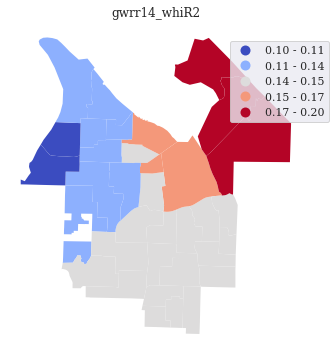

ValueError: Input must be 1- or 2-d.

In [16]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'white', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3936.885
Log-likelihood:                                                    -132.312
AIC:                                                                268.624
AICc:                                                               271.398
BIC:                                                               3819.559
R2:                                                                   0.147
Adj. R2:                                                              0.121

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

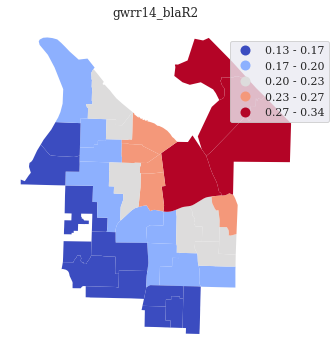

ValueError: Input must be 1- or 2-d.

In [17]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'black', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          56663.697
Log-likelihood:                                                    -178.980
AIC:                                                                361.960
AICc:                                                               364.734
BIC:                                                              56546.371
R2:                                                                   0.000
Adj. R2:                                                             -0.030

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

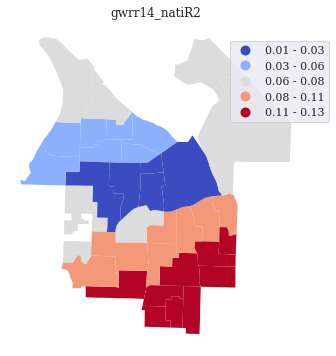

ValueError: Input must be 1- or 2-d.

In [18]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'native', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2889.285
Log-likelihood:                                                    -126.898
AIC:                                                                257.795
AICc:                                                               260.569
BIC:                                                               2771.958
R2:                                                                   0.156
Adj. R2:                                                              0.130

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

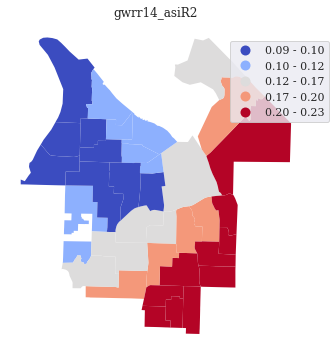

ValueError: Input must be 1- or 2-d.

In [19]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'asian', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          40988.381
Log-likelihood:                                                    -173.313
AIC:                                                                350.625
AICc:                                                               353.399
BIC:                                                              40871.055
R2:                                                                   0.024
Adj. R2:                                                             -0.006

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

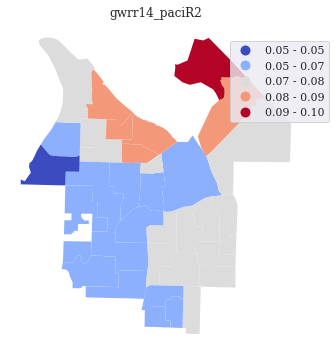

ValueError: Input must be 1- or 2-d.

In [20]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'pacific', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          29248.154
Log-likelihood:                                                    -167.407
AIC:                                                                338.814
AICc:                                                               341.588
BIC:                                                              29130.828
R2:                                                                   0.061
Adj. R2:                                                              0.032

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

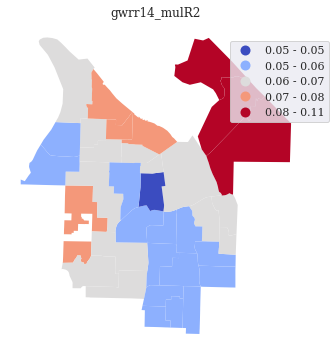

ValueError: Input must be 1- or 2-d.

In [21]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'multi', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           5265.592
Log-likelihood:                                                    -137.401
AIC:                                                                278.802
AICc:                                                               281.576
BIC:                                                               5148.266
R2:                                                                   0.239
Adj. R2:                                                              0.216

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

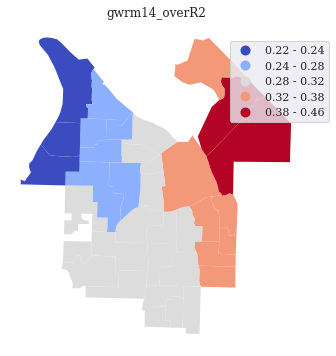

ValueError: Input must be 1- or 2-d.

In [22]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'overall', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3950.255
Log-likelihood:                                                    -132.371
AIC:                                                                268.742
AICc:                                                               271.516
BIC:                                                               3832.929
R2:                                                                   0.091
Adj. R2:                                                              0.064

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

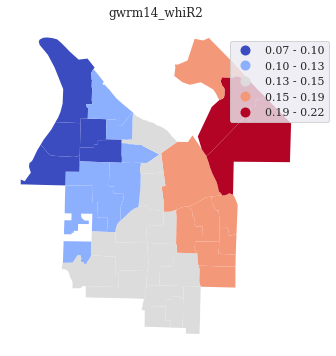

ValueError: Input must be 1- or 2-d.

In [23]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'white', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           9335.839
Log-likelihood:                                                    -147.423
AIC:                                                                298.845
AICc:                                                               301.619
BIC:                                                               9218.513
R2:                                                                   0.104
Adj. R2:                                                              0.077

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

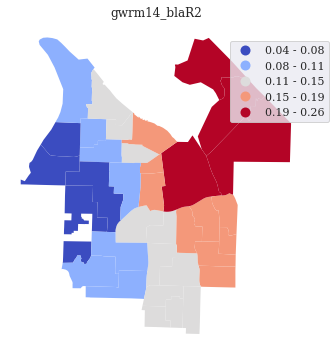

ValueError: Input must be 1- or 2-d.

In [24]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'black', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          53092.519
Log-likelihood:                                                    -177.841
AIC:                                                                359.681
AICc:                                                               362.455
BIC:                                                              52975.192
R2:                                                                   0.079
Adj. R2:                                                              0.051

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

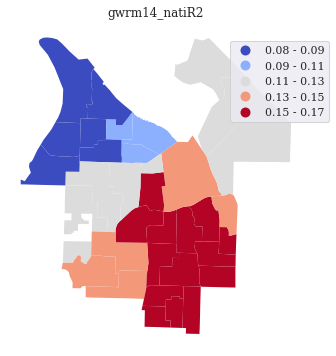

ValueError: Input must be 1- or 2-d.

In [25]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'native', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3199.913
Log-likelihood:                                                    -128.685
AIC:                                                                261.369
AICc:                                                               264.143
BIC:                                                               3082.587
R2:                                                                   0.133
Adj. R2:                                                              0.107

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

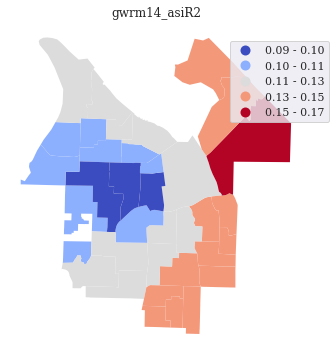

ValueError: Input must be 1- or 2-d.

In [26]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'asian', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          39539.075
Log-likelihood:                                                    -172.683
AIC:                                                                349.365
AICc:                                                               352.139
BIC:                                                              39421.748
R2:                                                                   0.091
Adj. R2:                                                              0.064

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

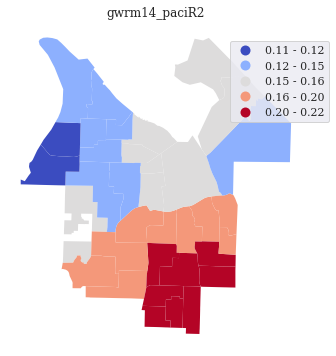

ValueError: Input must be 1- or 2-d.

In [27]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'pacific', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          45910.004
Log-likelihood:                                                    -175.297
AIC:                                                                354.594
AICc:                                                               357.368
BIC:                                                              45792.678
R2:                                                                   0.008
Adj. R2:                                                             -0.022

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

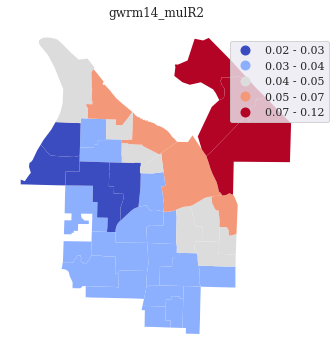

ValueError: Input must be 1- or 2-d.

In [28]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'multi', '2014', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           5939.698
Log-likelihood:                                                    -139.509
AIC:                                                                283.018
AICc:                                                               285.792
BIC:                                                               5822.371
R2:                                                                   0.196
Adj. R2:                                                              0.172

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

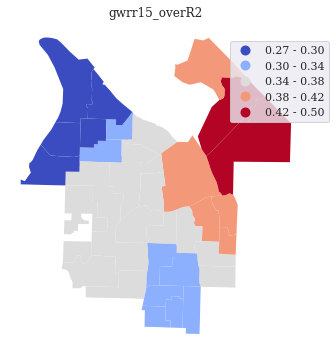

ValueError: Input must be 1- or 2-d.

In [29]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'overall', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           7124.885
Log-likelihood:                                                    -142.693
AIC:                                                                289.386
AICc:                                                               292.160
BIC:                                                               7007.558
R2:                                                                   0.017
Adj. R2:                                                             -0.013

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

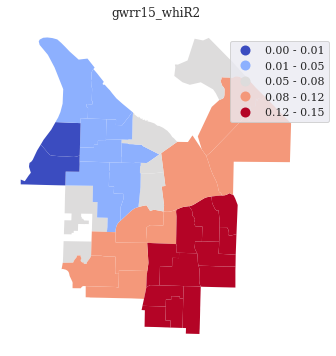

ValueError: Input must be 1- or 2-d.

In [30]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'white', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          13119.386
Log-likelihood:                                                    -153.377
AIC:                                                                310.753
AICc:                                                               313.527
BIC:                                                              13002.059
R2:                                                                   0.200
Adj. R2:                                                              0.176

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

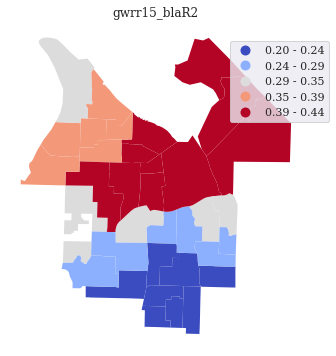

ValueError: Input must be 1- or 2-d.

In [31]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'black', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          18390.827
Log-likelihood:                                                    -159.287
AIC:                                                                322.575
AICc:                                                               325.349
BIC:                                                              18273.501
R2:                                                                   0.052
Adj. R2:                                                              0.023

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

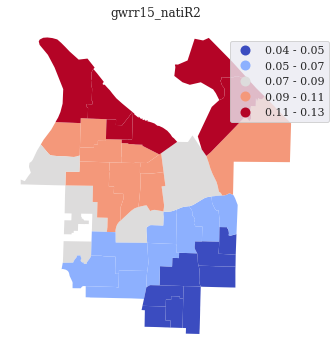

ValueError: Input must be 1- or 2-d.

In [32]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'native', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          10090.469
Log-likelihood:                                                    -148.783
AIC:                                                                301.566
AICc:                                                               304.340
BIC:                                                               9973.143
R2:                                                                   0.123
Adj. R2:                                                              0.096

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

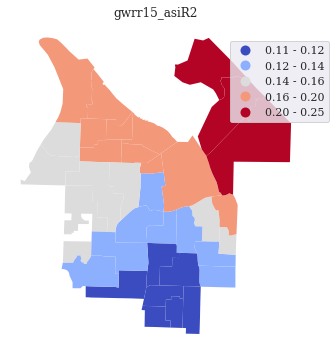

ValueError: Input must be 1- or 2-d.

In [33]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'asian', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          24014.238
Log-likelihood:                                                    -163.956
AIC:                                                                331.913
AICc:                                                               334.687
BIC:                                                              23896.912
R2:                                                                   0.000
Adj. R2:                                                             -0.030

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

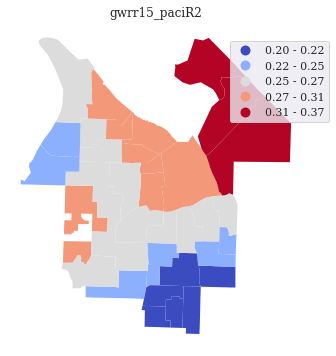

ValueError: Input must be 1- or 2-d.

In [34]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'pacific', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          14836.364
Log-likelihood:                                                    -155.529
AIC:                                                                315.058
AICc:                                                               317.832
BIC:                                                              14719.038
R2:                                                                   0.004
Adj. R2:                                                             -0.026

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

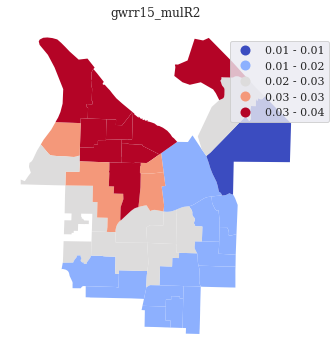

ValueError: Input must be 1- or 2-d.

In [35]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'read', 'multi', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6341.404
Log-likelihood:                                                    -140.654
AIC:                                                                285.308
AICc:                                                               288.083
BIC:                                                               6224.077
R2:                                                                   0.181
Adj. R2:                                                              0.157

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

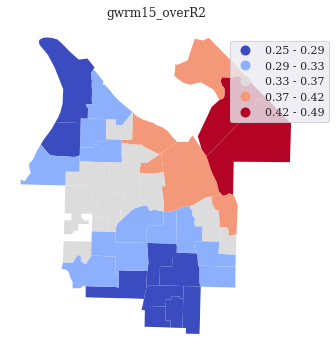

ValueError: Input must be 1- or 2-d.

In [36]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'overall', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           8499.067
Log-likelihood:                                                    -145.779
AIC:                                                                295.558
AICc:                                                               298.333
BIC:                                                               8381.740
R2:                                                                   0.010
Adj. R2:                                                             -0.020

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

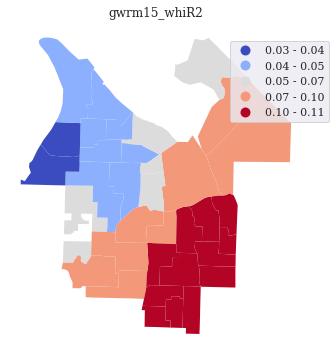

ValueError: Input must be 1- or 2-d.

In [37]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'white', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          18333.010
Log-likelihood:                                                    -159.232
AIC:                                                                322.465
AICc:                                                               325.239
BIC:                                                              18215.684
R2:                                                                   0.144
Adj. R2:                                                              0.118

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

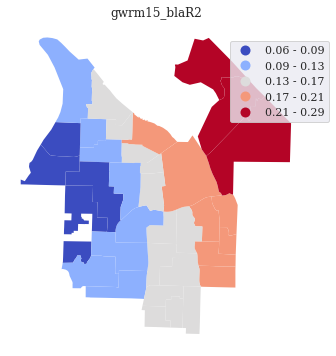

ValueError: Input must be 1- or 2-d.

In [38]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'black', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          21736.221
Log-likelihood:                                                    -162.212
AIC:                                                                328.424
AICc:                                                               331.198
BIC:                                                              21618.895
R2:                                                                   0.000
Adj. R2:                                                             -0.030

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

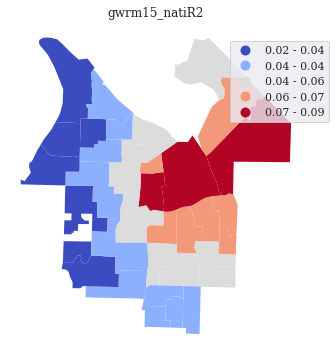

ValueError: Input must be 1- or 2-d.

In [39]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'native', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4325.112
Log-likelihood:                                                    -133.958
AIC:                                                                271.915
AICc:                                                               274.689
BIC:                                                               4207.785
R2:                                                                   0.168
Adj. R2:                                                              0.143

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

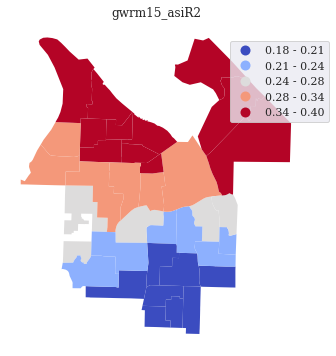

ValueError: Input must be 1- or 2-d.

In [40]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'asian', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          24233.420
Log-likelihood:                                                    -164.115
AIC:                                                                332.231
AICc:                                                               335.005
BIC:                                                              24116.094
R2:                                                                   0.024
Adj. R2:                                                             -0.005

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

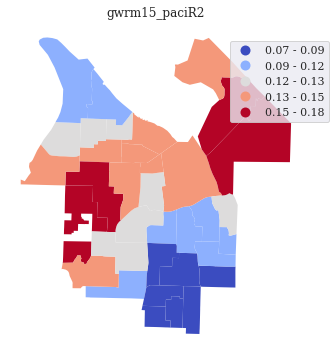

ValueError: Input must be 1- or 2-d.

In [41]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'pacific', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  35
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          16126.655
Log-likelihood:                                                    -156.988
AIC:                                                                317.977
AICc:                                                               320.751
BIC:                                                              16009.329
R2:                                                                   0.081
Adj. R2:                                                              0.053

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

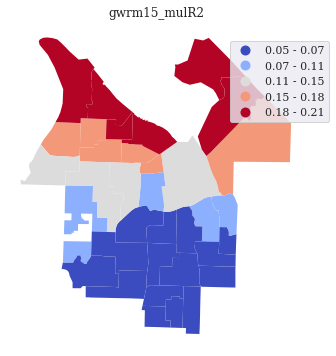

ValueError: Input must be 1- or 2-d.

In [42]:
altReg('other_data\polygons_points\Water\elem_fin_c.shp', 'POINT_X', 
              'POINT_Y', 35, 'math', 'multi', '2015', 0.3, 'gwrresults/alt/elem_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            854.411
Log-likelihood:                                                     -36.429
AIC:                                                                 76.857
AICc:                                                                82.857
BIC:                                                                835.990
R2:                                                                   0.276
Adj. R2:                                                              0.185

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

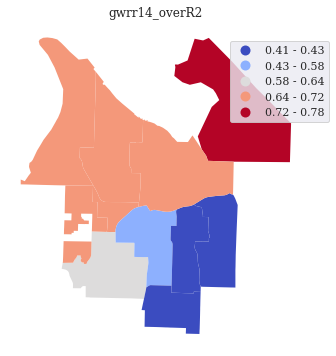

ValueError: Input must be 1- or 2-d.

In [43]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'overall', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            411.519
Log-likelihood:                                                     -32.776
AIC:                                                                 69.551
AICc:                                                                75.551
BIC:                                                                393.098
R2:                                                                   0.261
Adj. R2:                                                              0.169

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

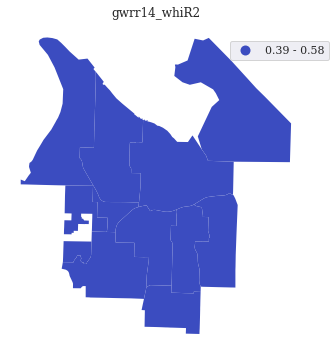

ValueError: Input must be 1- or 2-d.

In [44]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'white', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1318.858
Log-likelihood:                                                     -38.599
AIC:                                                                 81.198
AICc:                                                                87.198
BIC:                                                               1300.437
R2:                                                                   0.138
Adj. R2:                                                              0.030

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

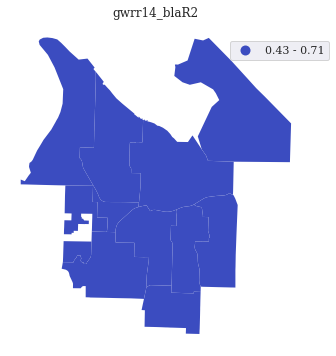

ValueError: Input must be 1- or 2-d.

In [45]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'black', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            679.263
Log-likelihood:                                                     -35.282
AIC:                                                                 74.563
AICc:                                                                80.563
BIC:                                                                660.842
R2:                                                                   0.000
Adj. R2:                                                             -0.125

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

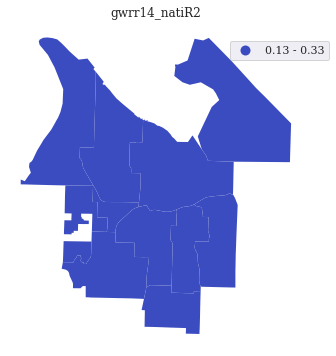

ValueError: Input must be 1- or 2-d.

In [46]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'native', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            653.909
Log-likelihood:                                                     -35.091
AIC:                                                                 74.183
AICc:                                                                80.183
BIC:                                                                635.489
R2:                                                                   0.021
Adj. R2:                                                             -0.102

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

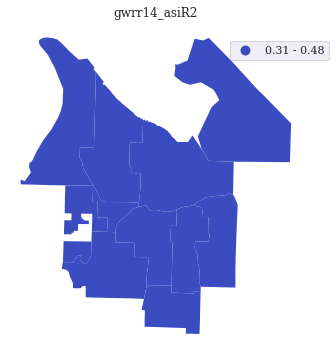

ValueError: Input must be 1- or 2-d.

In [47]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'asian', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2338.020
Log-likelihood:                                                     -41.462
AIC:                                                                 86.924
AICc:                                                                92.924
BIC:                                                               2319.600
R2:                                                                   0.294
Adj. R2:                                                              0.205

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

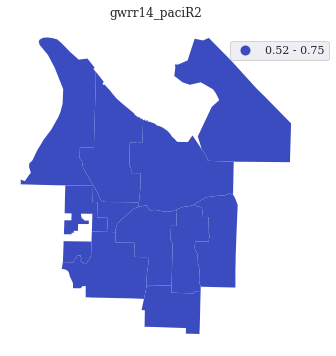

ValueError: Input must be 1- or 2-d.

In [48]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'pacific', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1184.753
Log-likelihood:                                                     -38.063
AIC:                                                                 80.126
AICc:                                                                86.126
BIC:                                                               1166.332
R2:                                                                   0.115
Adj. R2:                                                              0.005

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

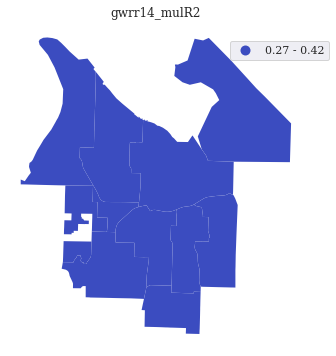

ValueError: Input must be 1- or 2-d.

In [49]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'multi', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1486.312
Log-likelihood:                                                     -39.197
AIC:                                                                 82.393
AICc:                                                                88.393
BIC:                                                               1467.892
R2:                                                                   0.161
Adj. R2:                                                              0.056

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

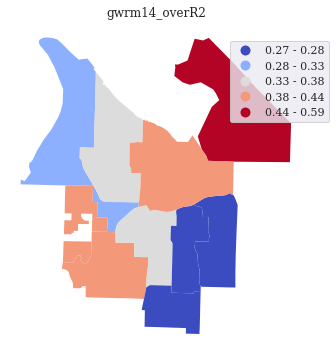

ValueError: Input must be 1- or 2-d.

In [50]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'overall', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1139.553
Log-likelihood:                                                     -37.868
AIC:                                                                 79.737
AICc:                                                                85.737
BIC:                                                               1121.132
R2:                                                                   0.107
Adj. R2:                                                             -0.004

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

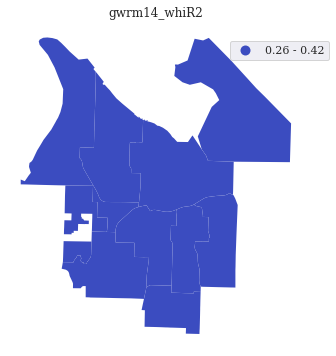

ValueError: Input must be 1- or 2-d.

In [51]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'white', '2014', 0.3, 'gwrresults/mid_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2823.188
Log-likelihood:                                                     -42.405
AIC:                                                                 88.809
AICc:                                                                94.809
BIC:                                                               2804.767
R2:                                                                   0.072
Adj. R2:                                                             -0.044

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

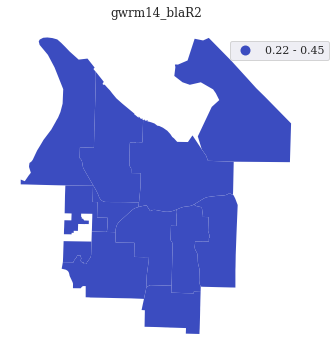

ValueError: Input must be 1- or 2-d.

In [52]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'black', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6665.165
Log-likelihood:                                                     -46.700
AIC:                                                                 97.399
AICc:                                                               103.399
BIC:                                                               6646.744
R2:                                                                   0.004
Adj. R2:                                                             -0.121

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

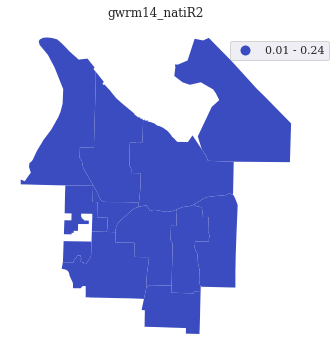

ValueError: Input must be 1- or 2-d.

In [53]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'native', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1255.779
Log-likelihood:                                                     -38.354
AIC:                                                                 80.708
AICc:                                                                86.708
BIC:                                                               1237.358
R2:                                                                   0.005
Adj. R2:                                                             -0.119

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

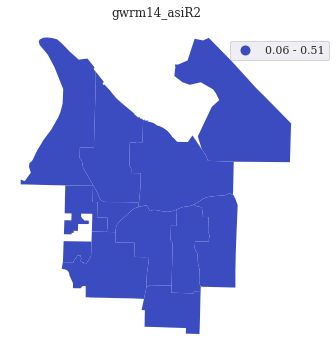

ValueError: Input must be 1- or 2-d.

In [54]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'asian', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3063.188
Log-likelihood:                                                     -42.813
AIC:                                                                 89.625
AICc:                                                                95.625
BIC:                                                               3044.768
R2:                                                                   0.291
Adj. R2:                                                              0.203

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

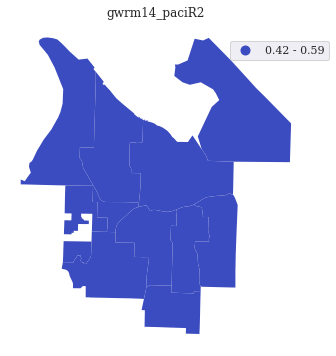

ValueError: Input must be 1- or 2-d.

In [55]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'pacific', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6097.696
Log-likelihood:                                                     -46.255
AIC:                                                                 96.510
AICc:                                                               102.510
BIC:                                                               6079.276
R2:                                                                   0.297
Adj. R2:                                                              0.209

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

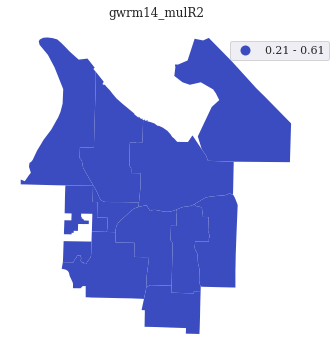

ValueError: Input must be 1- or 2-d.

In [56]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'multi', '2014', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            953.103
Log-likelihood:                                                     -36.975
AIC:                                                                 77.950
AICc:                                                                83.950
BIC:                                                                934.682
R2:                                                                   0.276
Adj. R2:                                                              0.185

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

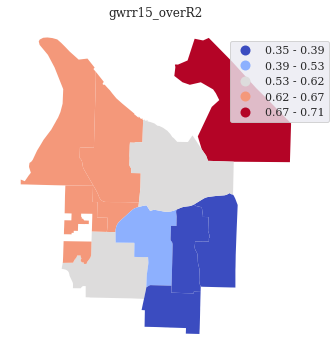

ValueError: Input must be 1- or 2-d.

In [59]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'overall', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            641.393
Log-likelihood:                                                     -34.995
AIC:                                                                 73.989
AICc:                                                                79.989
BIC:                                                                622.972
R2:                                                                   0.195
Adj. R2:                                                              0.094

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

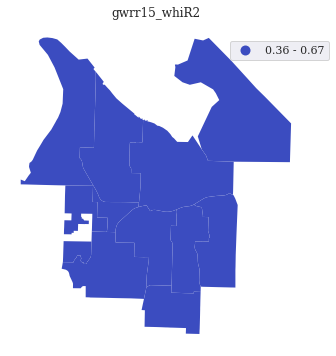

ValueError: Input must be 1- or 2-d.

In [60]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'white', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            913.701
Log-likelihood:                                                     -36.764
AIC:                                                                 77.528
AICc:                                                                83.528
BIC:                                                                895.281
R2:                                                                   0.146
Adj. R2:                                                              0.039

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

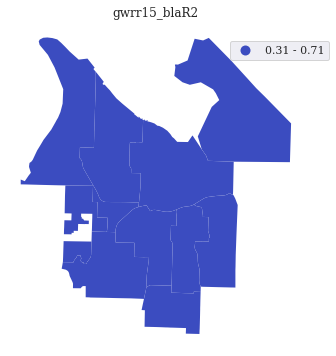

ValueError: Input must be 1- or 2-d.

In [61]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'black', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2817.770
Log-likelihood:                                                     -42.395
AIC:                                                                 88.790
AICc:                                                                94.790
BIC:                                                               2799.350
R2:                                                                   0.001
Adj. R2:                                                             -0.124

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

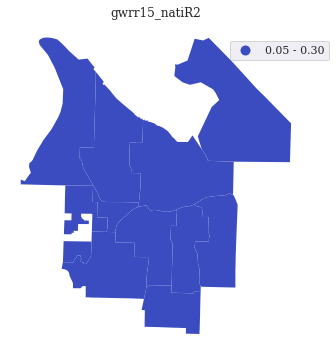

ValueError: Input must be 1- or 2-d.

In [62]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'native', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1438.133
Log-likelihood:                                                     -39.032
AIC:                                                                 82.064
AICc:                                                                88.064
BIC:                                                               1419.712
R2:                                                                   0.039
Adj. R2:                                                             -0.082

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

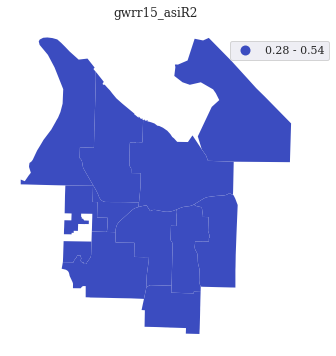

ValueError: Input must be 1- or 2-d.

In [63]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'asian', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4241.141
Log-likelihood:                                                     -44.439
AIC:                                                                 92.879
AICc:                                                                98.879
BIC:                                                               4222.721
R2:                                                                   0.067
Adj. R2:                                                             -0.050

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

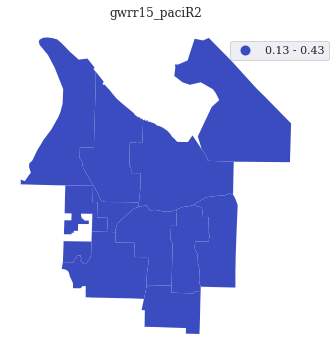

ValueError: Input must be 1- or 2-d.

In [64]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'pacific', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           5087.571
Log-likelihood:                                                     -45.349
AIC:                                                                 94.698
AICc:                                                               100.698
BIC:                                                               5069.150
R2:                                                                   0.321
Adj. R2:                                                              0.236

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

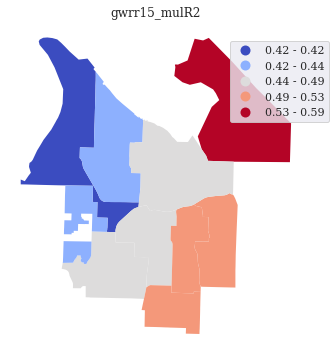

ValueError: Input must be 1- or 2-d.

In [65]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'read', 'multi', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            974.699
Log-likelihood:                                                     -37.087
AIC:                                                                 78.174
AICc:                                                                84.174
BIC:                                                                956.278
R2:                                                                   0.148
Adj. R2:                                                              0.041

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

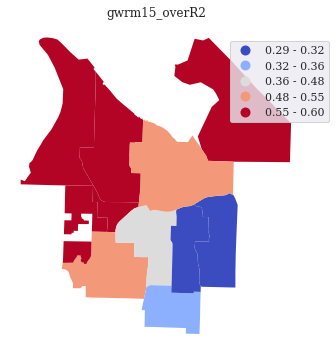

ValueError: Input must be 1- or 2-d.

In [66]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'overall', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 5)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            853.156
Log-likelihood:                                                     -36.421
AIC:                                                                 76.842
AICc:                                                                82.842
BIC:                                                                834.736
R2:                                                                   0.030
Adj. R2:                                                             -0.091

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

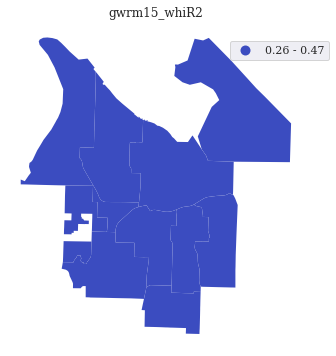

ValueError: Input must be 1- or 2-d.

In [67]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'white', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            921.070
Log-likelihood:                                                     -36.804
AIC:                                                                 77.608
AICc:                                                                83.608
BIC:                                                                902.649
R2:                                                                   0.123
Adj. R2:                                                              0.014

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

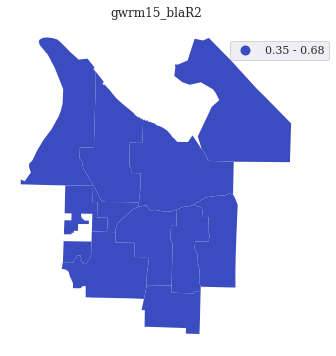

ValueError: Input must be 1- or 2-d.

In [68]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'black', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6057.577
Log-likelihood:                                                     -46.222
AIC:                                                                 96.444
AICc:                                                               102.444
BIC:                                                               6039.157
R2:                                                                   0.000
Adj. R2:                                                             -0.125

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

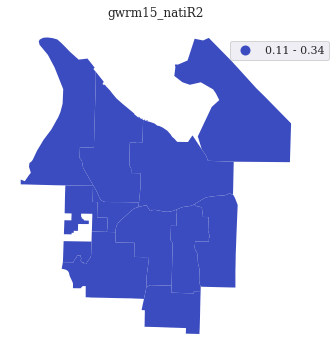

ValueError: Input must be 1- or 2-d.

In [69]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'native', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1810.774
Log-likelihood:                                                     -40.184
AIC:                                                                 84.368
AICc:                                                                90.368
BIC:                                                               1792.353
R2:                                                                   0.032
Adj. R2:                                                             -0.089

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

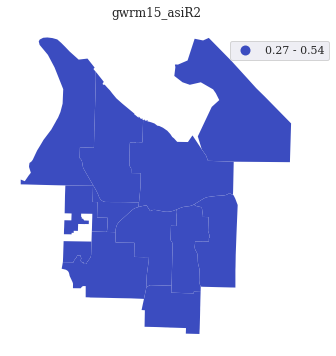

ValueError: Input must be 1- or 2-d.

In [15]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'asian', '2015', 0.3, 'gwrresults/alt/FIXTEST', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3220.917
Log-likelihood:                                                     -43.064
AIC:                                                                 90.127
AICc:                                                                96.127
BIC:                                                               3202.496
R2:                                                                   0.001
Adj. R2:                                                             -0.124

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

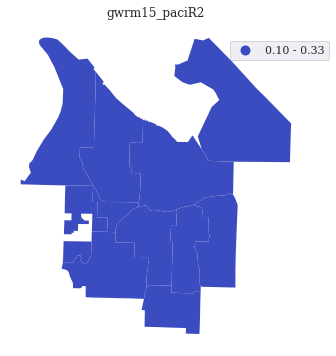

ValueError: Input must be 1- or 2-d.

In [71]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'pacific', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

Model type                                                         Gaussian
Number of observations:                                                  10
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6175.408
Log-likelihood:                                                     -46.318
AIC:                                                                 96.636
AICc:                                                               102.636
BIC:                                                               6156.987
R2:                                                                   0.109
Adj. R2:                                                             -0.002

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

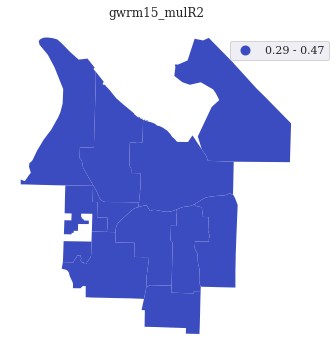

ValueError: Input must be 1- or 2-d.

In [72]:
altReg('other_data\polygons_points\Water\mid_fin_c.shp', 'POINT_X', 
              'POINT_Y', 10, 'math', 'multi', '2015', 0.3, 'gwrresults/alt/mid_ponly_', 1)

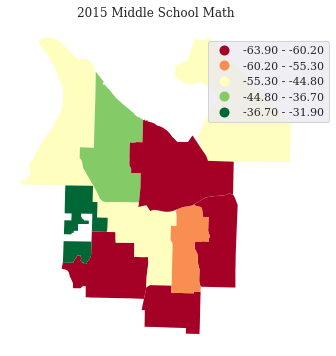

In [95]:
gdf = gpd.read_file('other_data\polygons_points\Schools_with_Data\mid_fin_dis.shp')

fig, ax = plt.subplots(figsize=(6, 6))
    
#sometimes, there aren't enough unique r^2s for a multi-class GWR
    
gdf.plot(column='m15_over', cmap = 'RdYlGn', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('2015 Middle School Math', fontsize=12)
ax.axis("off")
plt.savefig('E:/NONGIT Project_Resources/Mid_Mth_15.png',dpi=150, bbox_inches='tight')
plt.show()